In [43]:
#Official Phase Space Reconstructed Neural ODEs (PSR-NODE)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy 

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim),  # Output dimension matches input dimension
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(15, 1)  # Predicting the target from transformed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]

def phase_space_reconstruction(series, delay, embedding_dim):
    N = len(series)
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim))
    for i in range(embedding_dim):
        reconstructed[:, i] = series[i * delay : N - (embedding_dim - i - 1) * delay]
    return reconstructed

def preprocess_data(data, delay, embedding_dim):
    scaler = MinMaxScaler()
    features = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
    target = data['Close']

    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

    reconstructed_features = []
    for i in range(features_scaled.shape[1]):
        psr = phase_space_reconstruction(features_scaled[:, i], delay, embedding_dim)
        reconstructed_features.append(psr)

    reconstructed_features = np.concatenate(reconstructed_features, axis=1)
    return reconstructed_features, target_scaled[embedding_dim - 1:]

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'AAPL.csv'
raw_data = load_data(file_name)
delay, embedding_dim = 1, 3
features, target = preprocess_data(raw_data, delay, embedding_dim)

# NeuralODE setup and training
func = ODEFunc(features.shape[1])
neural_ode_model = NeuralODEModel(func)

# Split the data into training and testing sets (80% train, 20% test)
split_idx = int(len(features) * 0.8)
train_features, test_features = features[:split_idx], features[split_idx:]
train_target, test_target = target[:split_idx], target[split_idx:]

# K-Fold Cross Validation
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(features):
    train_features, val_features = features[train_index], features[test_index]
    train_target, val_target = target[train_index], target[test_index]

    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, train_features, train_target, val_features, val_target, epochs=100, lr=0.001, patience=10)
# Forecast on the testing set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test = trained_model(test_tensor).detach().numpy()

# Inverse transform the scaled data to original scale for visualization
scaler = MinMaxScaler()
scaler.fit(raw_data[['Close']])
actual_test_prices = scaler.inverse_transform(test_target.reshape(-1, 1))
predicted_test_prices = scaler.inverse_transform(forecasted_test.reshape(-1, 1))

# Forecasting and evaluation
forecasted = trained_model(torch.from_numpy(features).float()).detach().numpy()
mae = mean_absolute_error(target, forecasted)
rmse = np.sqrt(mean_squared_error(target, forecasted))

print(f"MAE: {mae}, RMSE: {rmse}")

Epoch 0, Train Loss: 0.07284978032112122, Val Loss: 0.03887002915143967
Epoch 10, Train Loss: 0.009387057274580002, Val Loss: 0.012647777795791626
Epoch 20, Train Loss: 0.0020382225047796965, Val Loss: 0.005975533276796341
Early stopping triggered at epoch 25
Epoch 0, Train Loss: 0.0005113918450661004, Val Loss: 0.0017063480336219072
Epoch 10, Train Loss: 0.0003758071979973465, Val Loss: 0.00041716123814694583
Epoch 20, Train Loss: 0.0003136673185508698, Val Loss: 0.0003829629858955741
Epoch 30, Train Loss: 0.00023943120322655886, Val Loss: 0.0003283045662101358
Epoch 40, Train Loss: 0.00019041600171476603, Val Loss: 0.00024070539802778512
Epoch 50, Train Loss: 0.00015793142665643245, Val Loss: 0.00018672477744985372
Epoch 60, Train Loss: 0.00013176527863834053, Val Loss: 0.00014488381566479802
Epoch 70, Train Loss: 0.00011082876153523102, Val Loss: 0.00011391492444090545
Epoch 80, Train Loss: 9.357814269606024e-05, Val Loss: 8.890558819985017e-05
Epoch 90, Train Loss: 7.97885659267194

In [5]:
#Official ODEs
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torchdiffeq import odeint
from sklearn.model_selection import KFold
import copy 
from sklearn.model_selection import TimeSeriesSplit

class ODEFunc(nn.Module):
    def __init__(self, dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 50),  # 'dim' should match the number of features in your input data
            nn.Tanh(),
            nn.Linear(50, dim),
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODEModel(nn.Module):
    def __init__(self, ode_func, num_features):
        super(NeuralODEModel, self).__init__()
        self.ode_func = ode_func
        self.linear = nn.Linear(num_features, 1)  # Adjust to match the number of reconstructed features

    def forward(self, x):
        ode_result = odeint(self.ode_func, x, torch.tensor([0., 1.]))[1]
        return self.linear(ode_result)

def load_data(file_name):
    data = pd.read_csv(file_name)
    return data[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']]


def phase_space_reconstruction(series, delay, embedding_dim):
    N, num_features = series.shape
    reconstructed = np.zeros((N - (embedding_dim - 1) * delay, embedding_dim * num_features))
    for i in range(num_features):
        for d in range(embedding_dim):
            reconstructed[:, i * embedding_dim + d] = series[d * delay: N - (embedding_dim - d - 1) * delay, i]
    return reconstructed

def preprocess_data(data, delay, embedding_dim, scaler_features=None, scaler_target=None):
    # Separate features and target
    features = data.iloc[:, :-1]  # All columns except 'Close'
    target = data.iloc[:, -1].values.reshape(-1, 1)  # Just the 'Close' column

    # Initialize and fit/transform scalers
    if scaler_features is None:
        scaler_features = MinMaxScaler()
        features = scaler_features.fit_transform(features)
    else:
        features = scaler_features.transform(features)

    if scaler_target is None:
        scaler_target = MinMaxScaler()
        target = scaler_target.fit_transform(target)
    else:
        target = scaler_target.transform(target)

    # Apply phase space reconstruction
    reconstructed_features = phase_space_reconstruction(features, delay, embedding_dim)
    target = target[delay * (embedding_dim - 1):]

    return reconstructed_features, target.squeeze(), scaler_features, scaler_target

def train_neural_ode_with_validation(model, train_data, train_target, val_data, val_target, epochs, lr, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_tensor = torch.from_numpy(train_data).float()
    train_target_tensor = torch.from_numpy(train_target).float().squeeze()
    val_tensor = torch.from_numpy(val_data).float()
    val_target_tensor = torch.from_numpy(val_target).float().squeeze()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        prediction = model(train_tensor).squeeze()
        loss = criterion(prediction, train_target_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_prediction = model(val_tensor).squeeze()
            val_loss = criterion(val_prediction, val_target_tensor)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    model.load_state_dict(best_model_wts)
    return model

# Main execution
file_name = 'BABA.csv'
raw_data = load_data(file_name)

# Split the raw data into training and testing sets (80% train, 20% test)
split_idx = int(len(raw_data) * 0.8)
train_data, test_data = raw_data[:split_idx], raw_data[split_idx:]

# Preprocess the training data
train_features, train_target, scaler_features, scaler_target = preprocess_data(
    train_data, 1, 3
)

# Determine the number of features in your input data after phase space reconstruction
num_features_reconstructed = train_features.shape[1]

# Initialize your NeuralODE model with the correct number of input features
neural_ode_model = NeuralODEModel(ODEFunc(dim=num_features_reconstructed), num_features_reconstructed)

# Preprocess the test data using the same scalers
test_features, test_target, _, _ = preprocess_data(
    test_data, 1, 3, scaler_features, scaler_target
)

# Ensure the target is in the correct shape for training and testing
train_target = train_target.squeeze()
test_target = test_target.squeeze()

# Number of splits for TimeSeriesSplit
n_splits = 5

# Initialize TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(train_features):
    # Split the data into training and validation sets for each fold
    kf_train_features, kf_val_features = train_features[train_index], train_features[test_index]
    kf_train_target, kf_val_target = train_target[train_index], train_target[test_index]
    
    # Train the model with validation
    trained_model = train_neural_ode_with_validation(neural_ode_model, kf_train_features, kf_train_target, kf_val_features, kf_val_target, epochs=100, lr=0.001, patience=10)
    
    # After training, make predictions on the test set
test_tensor = torch.from_numpy(test_features).float()
forecasted_test_scaled = trained_model(test_tensor).detach().numpy()

# The target values are already scaled, as they come from the preprocessing step
# So there's no need to scale them again, just ensure they are the correct shape
test_target_scaled = test_target.reshape(-1, 1)

# Calculate MAE and RMSE on the scaled test set predictions
mae_scaled = mean_absolute_error(test_target_scaled, forecasted_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(test_target_scaled, forecasted_test_scaled))

print(f"Scaled MAE: {mae_scaled}, Scaled RMSE: {rmse_scaled}")

Epoch 0, Train Loss: 0.2473054975271225, Val Loss: 0.2092433124780655
Epoch 10, Train Loss: 0.08035483211278915, Val Loss: 0.061575111001729965
Epoch 20, Train Loss: 0.012961650267243385, Val Loss: 0.00729400385171175
Epoch 30, Train Loss: 0.007169653661549091, Val Loss: 0.007661108858883381
Early stopping triggered at epoch 34
Epoch 0, Train Loss: 0.0049175480380654335, Val Loss: 0.15978646278381348
Epoch 10, Train Loss: 0.0015468749916180968, Val Loss: 0.045272212475538254
Epoch 20, Train Loss: 0.00031867597135715187, Val Loss: 0.006088642869144678
Epoch 30, Train Loss: 0.00012487228377722204, Val Loss: 0.00017185280739795417
Early stopping triggered at epoch 40
Epoch 0, Train Loss: 0.0001404403301421553, Val Loss: 0.001466649817302823
Epoch 10, Train Loss: 0.00025016054860316217, Val Loss: 0.0002255768922623247
Epoch 20, Train Loss: 0.0001636452943785116, Val Loss: 0.00025587546406313777
Epoch 30, Train Loss: 0.00010653987555997446, Val Loss: 0.00017349288100376725
Epoch 40, Train L

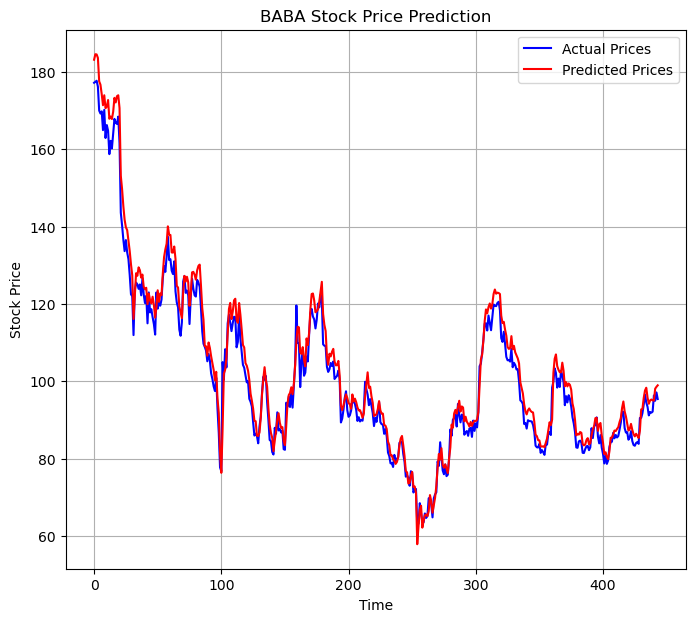

In [6]:
import matplotlib.pyplot as plt

# Assuming you have 'scaler_target' from your preprocessing step
# Reverse scaling for predicted and actual values
predicted_test_unscaled = scaler_target.inverse_transform(forecasted_test_scaled)
actual_test_unscaled = scaler_target.inverse_transform(test_target_scaled.reshape(-1, 1))

# Plotting the results for the test set
plt.figure(figsize=(8, 7))
plt.plot(actual_test_unscaled, label='Actual Prices', color='blue')
plt.plot(predicted_test_unscaled, label='Predicted Prices', color='red')
plt.title('BABA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()